In [1]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import numpy as np 
import Correlated_Poisson_Process as pp
import Plot as plot

# 1. Generate spike trains for neurons with higher-order correlations

In [6]:
# # generate parallel spikes with different rates
# spike_trains = pp.generate_parallelST([0.2,0.2,0.4,0.4,0.4,0.2,0.1], 10) 
# marked_process1 = pp.parallelST_to_markedProcess(spike_trains)
# # reverse marked process to parallel spike trains. 
# components = pp.markedProcess_to_components(marked_process1)

# correlatedST1 = pp.markedProcess_to_correlatedST(marked_process1)

# # generate marked process with list of rates
# marked_process2 = pp.generate_markedProcess([0.5,0.6,0.7,0.4,0.4,0.4,0.8], 50)
# correlatedST2 = pp.markedProcess_to_correlatedST(marked_process2)

# # use rate distribution to generate marked process directly
# marked_process3 = pp.direct_markedProcess([0.5,0.4,0.3,0.4,0.4,0.6,0.5], 10)
# correlatedST3 = pp.markedProcess_to_correlatedST(marked_process3)


# # # plot corrleated poisson process. Same amplitude has same color
# # plot.colorPlot_correlatedST(marked_process3, color_key='amplitudes')
# # # plot corrleated poisson process. Spikes coming from same component have same color.
# # # Color map can be changed, default is plt.cm.hsv
# # import matplotlib.pyplot as plt
# # plot.colorPlot_correlatedST(marked_process3, color_key='components',color_map = plt.cm.tab10)

In [5]:
# counts = np.zeros(L, dtype = int)
# for spikes in correlatedST2:
#     count, bins = np.histogram(spikes, bins = L, density = False)
#     print(count, bins)
#     counts = counts + count
# print(counts, len(counts))
# counts2, bins, patches = plt.hist(correlatedST2,L, density=False, stacked=True, align='mid', alpha = 0.8)
# print(counts2, bins)
# counts2 = np.sum(counts2, axis=0)
# print(counts2, len(counts2))

In [44]:
T = 50  # observation duration
L = 30  # number of bins
h = T/L # bin size
y = []
nv = 3 #number of first firing rates to be estimated
sample_size = 50  # number of sampled theta and y
theta = np.arange(-np.pi, np.pi, step = 2 * np.pi / sample_size)
print(np.shape(theta))

(50,)


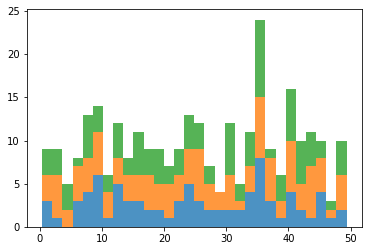

In [45]:
#for i in range(sample_size):
marked_process2 = pp.generate_markedProcess([0.5,0.6,0.7,0.4,0.4,0.4,0.8], 50)
correlatedST2 = pp.markedProcess_to_correlatedST(marked_process2)    

count, bins, patches = plt.hist(correlatedST2,L, density=False, stacked=True, align='mid', alpha = 0.8)
#plt.clf()
y = []
counts = np.sum(count, axis =0)
z_l =[0] * L + 1j * counts
for tt in theta:
    gamma_est = 1/L * np.sum(np.e ** (z_l * tt))
    y.append(1/h * np.log(gamma_est))


In [46]:
X = np.zeros((sample_size, nv+1))
for i in range(sample_size):
    X[i,:] = np.e**((nv+1) * theta[i]) 
X[:,nv] = 1

lambda_est = np.dot(np.linalg.pinv(np.dot(X.T,X)),np.dot(X.T,y)) # lambda_est = (X^T X)^(-1) X^T y
print(lambda_est)

[ 2.99833727e-07-7.82148735e-07j  2.99832814e-07-7.82148717e-07j
  2.99832814e-07-7.82148717e-07j -1.02985237e+00+2.06045703e-02j]


In [39]:
import scipy.integrate as integrate
n_l =[0] * 3 - 1j * (np.arange(nv)+1)
# def v_esti(t):
#     return 1/h * np.log( 1/ L * np.sum (np.e ** (z_l * t)))* np.e**(-n_l *t)
result = 1 / (2*np.pi) * integrate.quad(, -np.pi, np.pi)

TypeError: only size-1 arrays can be converted to Python scalars

# 2. Thinning process

## 2.1 Thinning a poissonian spike train

In [81]:
rate = 4       # rate (λ) of the target spike train
cv = 1       # coefficiant of variation (cv) of the target spike train
T = 10 
sigma = np.sqrt(np.log(cv**2 +1))             # analytical expression of σ
mu = -0.5 * np.log(rate**2 * (cv**2 +1))      # analytical expression of μ    

#define hazard function
def hazard(t):
    pdf = lognorm.pdf(t, sigma, np.exp(mu))
    sf = lognorm.sf(t, sigma, np.exp(mu))
    return pdf / sf

# define R_m, which is a bit greater than the peak value of hazard function.   
x = np.linspace(0, T, 300)
R_m = max(hazard(x)) * 1.1
print('R_m: ', R_m)

S = pp.generate_parallelST([R_m], T)[0] # stimulate a Poisson process with rate R_m
n = len(S)
U = np.random.uniform(0,R_m, n) # draw n random values between [0, R_m)
t_latest = S[0] 
new_S = [t_latest]
# For each spike draw a random value between [0, R_m). If the random value
# greater than the value of hazard function, reject the spike and continue
# the hazard function until the random value is no greater than the hazard 
# function. Then save the spike and reset the hazard function.
for i in range(1,n):
    if U[i] <= hazard([S[i]-t_latest]):
        t_latest = S[i]
        new_S.append(t_latest)
# print the number of spikes before and after thinning
print(len(S))
print(len(new_S))

R_m:  1.0559048641923061
9
7


## 2.2 Visualize the thinning process 

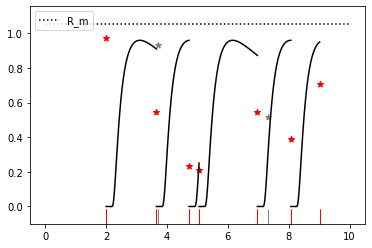

In [82]:
####plot the thinning process. Hazard function is not a monotonic. Grey spikes are rejected. Red spikes are kept.

plt.figure()
for i in range(len(new_S)-1):
    xs = np.linspace(new_S[i], new_S[i+1], 100)
    plt.plot(xs, hazard(xs-new_S[i]), c = 'k')
# plot the last part of harzard function, where it equals 0
x_tail = np.linspace(new_S[-1], S[-1], 50)
plt.plot(x_tail, hazard(x_tail-new_S[-1]), c = 'k')
# plot the spikes
y= np.empty(len(S))
y.fill(-0.1) 
y_new = np.empty(len(new_S))
y_new.fill(-0.1) 
new_U = U[S.searchsorted(new_S)] # find corresponding U for new_S
plt.scatter(S, U, marker = '*', c = 'gray')
plt.scatter(new_S, new_U, marker = '*', c = 'r')
plt.plot(S, y, marker = '|', linestyle = '', markersize=30, c = 'gray')
plt.plot(new_S, y_new, marker = '|', linestyle = '', markersize=30, c = 'r')
plt.plot(x, [R_m]*len(x), ':k', label = 'R_m')
plt.ylim(-0.1, R_m+0.1);
plt.legend(loc = "upper left")

# 3. Validation
Stimulate a Poisson process and thin it. Plot the ISI distribution of newly generated spike train. Validate that it is the desired lognormal distribution.

In [83]:
rate = 40       # rate (λ) of the target spike train
cv = 0.2        # coefficiant of variation (cv) of the target spike train
T = 500 
sigma = np.sqrt(np.log(cv**2 +1))             # analytical expression of σ
mu = -0.5 * np.log(rate**2 * (cv**2 +1))      # analytical expression of μ

def hazard(t):
    pdf = lognorm.pdf(t, sigma, np.exp(mu)) # probability density function
    sf = lognorm.sf(t, sigma, np.exp(mu))   # survival function
    return pdf / sf

# define R_m, which is a bit greater than peak value of hazard function.
# With bigger R_m more spikes will be rejected. With smaller R_m, more 
# spikes will be kept, which makes an efficient thinning process.
x = np.linspace(0, T, 300)
R_m = max(hazard(x)) * 1.1 # magnification factor 1.1. It can be replaced.

S = pp.generate_parallelST([R_m], T)[0] # Poisson process with rate R_m
new_S = pp.thinning(S, rate, cv, T)

# print the number of spikes before and after thinning
print(len(S))
print(len(new_S))
isi_logn = np.diff(new_S)

5362
485


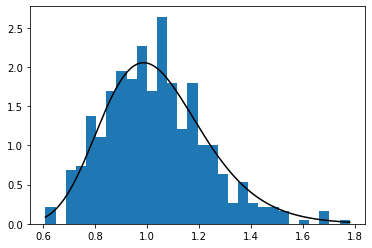

In [84]:
# plot the histogramm of ISI and the pdf curve 
plt.figure()
count, bins, ignored = plt.hist(isi_logn,30, density=True, align='mid')
xs = np.linspace(min(bins),max(bins), 300)
pdf =lognorm.pdf(xs, sigma, np.exp(mu))
plt.plot(xs, pdf, c = 'k')